<a href="https://colab.research.google.com/github/AdamStajer07/pytorchTutorial/blob/main/03_pytorch_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch Workflow

src:
https://www.learnpytorch.io/01_pytorch_workflow/

In [444]:
what_were_covering = {1: "data (prepare and load)",
                      2: "build model",
                      3: "fitting the model to data (training)",
                      4: "making predictions and evaluting a model (interface)",
                      5: "saving and loading a model",
                      6: "putting it all together"}
what_were_covering

{1: 'data (prepare and load)',
 2: 'build model',
 3: 'fitting the model to data (training)',
 4: 'making predictions and evaluting a model (interface)',
 5: 'saving and loading a model',
 6: 'putting it all together'}

In [445]:
import torch
from torch import nn # nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt
import numpy as np

torch.__version__

'2.5.0+cu121'

## 1. Data (preparing and loading)

Data can be almost anything.. in ml
* Excel speadsheet
* Images of any kind
* Videos
* Audio
* Text
* etc

ML is a game of two parts:
1. Get data into a numerical representation.
2. Build a model to learn patterns in that numerical representation

In [446]:
# let's create a data using linear regresion (y = ax + b)

weight = 0.7 #a
bias = 0.3 #b

start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1) #x
y = weight * X + bias

X[:10], y[:10], len(X), len(y)

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]),
 50,
 50)

### Spliting data into training and test sets (!IMPORTANT)

In [447]:
 # Create a train/test split
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [448]:
#Visualize train data with matplotlib

def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  if predictions is not None:
    # Plot the predictions in red (predictions were made on the test data)
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 14});

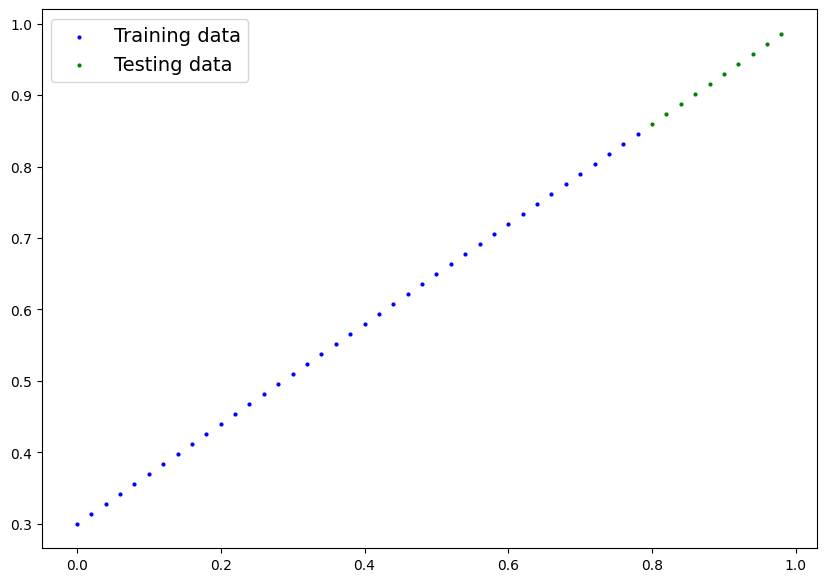

In [449]:
plot_predictions()

## 2. Build model

What model does:
* Start with random values (weight & bias)
* Look at training data and adjust the random values to better represent the ideal values

Two main algorithms:
1. Gradient descent
2. Backpropagation

In [450]:
# Create linear regression model class
class LinearRegressionModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.weights = nn.Parameter(torch.randn(1,
                                            requires_grad=True,
                                            dtype=torch.float))
    self.bias = nn.Parameter(torch.randn(1,
                                         requires_grad=True,
                                         dtype=torch.float))
  # Foward method to define the computation in the model
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.weights * x + self.bias

### Pytorch model building essentials

* torch.nn -  contains all of the buildings for computational graphs ( a neural network can be considered a computational graph)
* torch.nn.Parameter - what parameters shuld our model try and learn, often a PyTorch layer from torch.nn will set these for us
* torch.nn.Module - the base class for all neural network modules, if you subclass it, you should overwrite forward()
* torch.optim - this where the oprimizers in PyTorch live, they will help with gradient descent
* def forward() - All nn.Module subclasses require tou to oerwrite forward(), this method defines what happens in the forward computation

### Checking the contents of our PyTorch model

.parameters()

In [451]:
# Create a random seed
torch.manual_seed(42)

#Create an instance of the model (this is a subclass of nn.Module)
model_0 = LinearRegressionModel()

list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [452]:
# List named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Making prediction using `torch.inference_mode()`

In [453]:
# Make predictions with model
with torch.inference_mode():
    y_preds = model_0(X_test)

y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

In [454]:
y_test

tensor([[0.8600],
        [0.8740],
        [0.8880],
        [0.9020],
        [0.9160],
        [0.9300],
        [0.9440],
        [0.9580],
        [0.9720],
        [0.9860]])

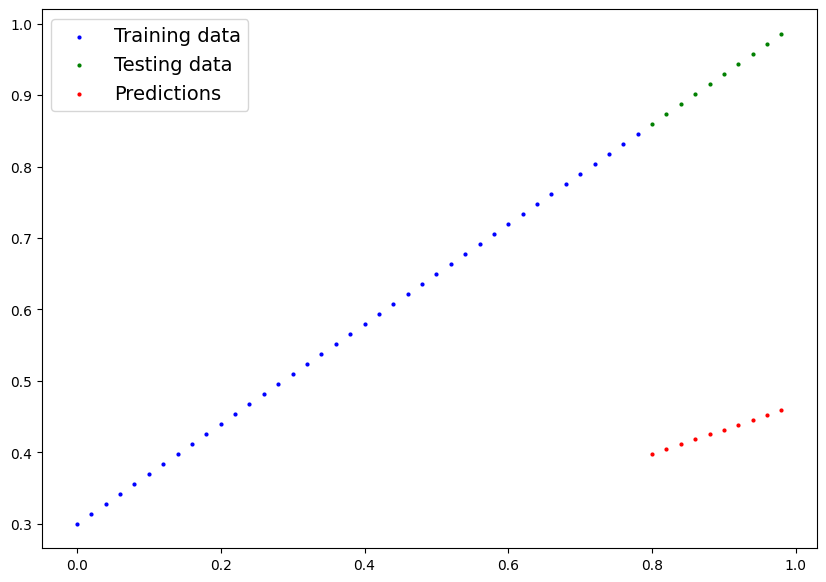

In [455]:
plot_predictions(predictions=y_preds)

## 3. Train model

The whole idea of training is for a model to move from some *unknown* parameters (these may be random) to some *known* parameters. Or in other words from a poor repsresentation of the data to a better representation of the data.

One way to measure how poor or how wrong your models predictions are is to use a loss function

* Note: Loss function may also be called cost function or criterion in different areas.

Things we need to train:

* **Loss function:** a function to measure how wrong your model's predictions are to the ideal outputs, lower is better

* **Optimizer**: takes into account the loss of a model and adjusts the model's
parameter (e.g. weight & bias) to improve the loss function

And specifically for PyTorch we need:
* A training loop
* A testing loop

In [456]:
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [457]:
# Setup a loss function
loss_fn = nn.L1Loss()

# Setup an optimizer (stochastic gradient descent)
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.01) #lr = learning rate = possibly the most important hyperparameter you can set

### Building a training loop (and a testing loop) in PyTorch

in training loop we need:
0. Loop through the data
1. Forward pass (this involves data moving through our model's `forward()` function) to make predictions on data - also called forward propagation
2. Calculate the loss (compare forward pass predictions to ground truth labels)
3. Optimizer zero grad
4. Loss backward - move backwards through the network to calculate the gradients of each of the parameters of our model with respect to the loss (**backpropagation**)
5. Optimizer step - use the optimizer to adjust our model's parameters to try and improve the loss (**gradient descent**)

In [458]:
X_test, y_test

(tensor([[0.8000],
         [0.8200],
         [0.8400],
         [0.8600],
         [0.8800],
         [0.9000],
         [0.9200],
         [0.9400],
         [0.9600],
         [0.9800]]),
 tensor([[0.8600],
         [0.8740],
         [0.8880],
         [0.9020],
         [0.9160],
         [0.9300],
         [0.9440],
         [0.9580],
         [0.9720],
         [0.9860]]))

In [459]:
model_0.state_dict()
#OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [460]:
# An epoch is one loop through the data... (this is a hyperparameter cause we've set itself)
epochs = 200

#Track different values
epoch_count = []
loss_values = []
test_loss_values = []

### Training
#0. Loop through the data
for epoch in range(epochs):
  #Set the model to training mode
  model_0.train() #train mode in PyTorch sets all parameters that require gradients to require gradients

  #1. Forward pass
  y_pred = model_0(X_train)

  #2. Calculate the loss

  loss = loss_fn(y_pred, y_train)
  #print(f"loss: {loss}")

  #3. Optimizer zero grad
  optimizer.zero_grad()

  #4. Perform backpropagation on the loss with respect to the parameters of the model
  loss.backward()

  #5. Step the optimizer (perform gradient descent)
  optimizer.step() # By default how the optimizre changes will acculumate through the loop so... we have to zero them above in step 3 iteration of the loop

  ### Testing
  model_0.eval() #turns off gradient tracking
  with torch.inference_mode():
    #1. Do the forward pass
    test_pred = model_0(X_test)

    #2. Calculate the loss
    test_loss = loss_fn(test_pred, y_test)

  if epoch % 10 == 0:
    epoch_count.append(epoch)
    loss_values.append(loss)
    test_loss_values.append(test_loss)
    print(f"Epoch: {epoch} | Test: {loss} | Test loss {test_loss}")
    model_0.state_dict()

Epoch: 0 | Test: 0.31288138031959534 | Test loss 0.48106518387794495
Epoch: 10 | Test: 0.1976713240146637 | Test loss 0.3463551998138428
Epoch: 20 | Test: 0.08908725529909134 | Test loss 0.21729660034179688
Epoch: 30 | Test: 0.053148526698350906 | Test loss 0.14464017748832703
Epoch: 40 | Test: 0.04543796554207802 | Test loss 0.11360953003168106
Epoch: 50 | Test: 0.04167863354086876 | Test loss 0.09919948130846024
Epoch: 60 | Test: 0.03818932920694351 | Test loss 0.08886633068323135
Epoch: 70 | Test: 0.03476089984178543 | Test loss 0.0805937647819519
Epoch: 80 | Test: 0.03132382780313492 | Test loss 0.07232122868299484
Epoch: 90 | Test: 0.02788739837706089 | Test loss 0.06473556160926819
Epoch: 100 | Test: 0.024458957836031914 | Test loss 0.05646304413676262
Epoch: 110 | Test: 0.021020207554101944 | Test loss 0.04819049686193466
Epoch: 120 | Test: 0.01758546568453312 | Test loss 0.04060482233762741
Epoch: 130 | Test: 0.014155393466353416 | Test loss 0.03233227878808975
Epoch: 140 | Tes

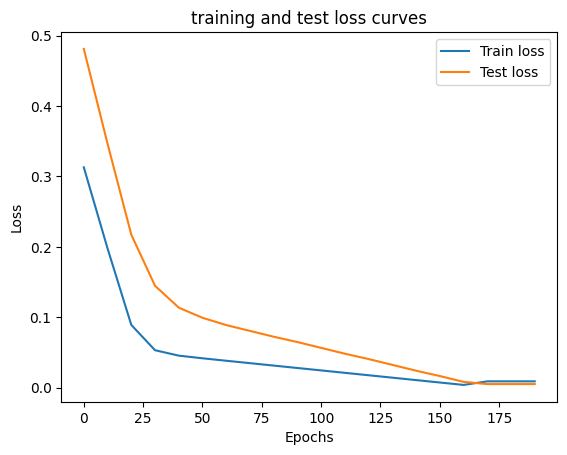

In [461]:
#Plot the loss curves
plt.plot(epoch_count, np.array(torch.tensor(loss_values).numpy()), label="Train loss")
plt.plot(epoch_count, np.array(torch.tensor(test_loss_values).numpy()), label="Test loss")
plt.title("training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

In [462]:
weight, bias, model_0.state_dict()

(0.7,
 0.3,
 OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))]))

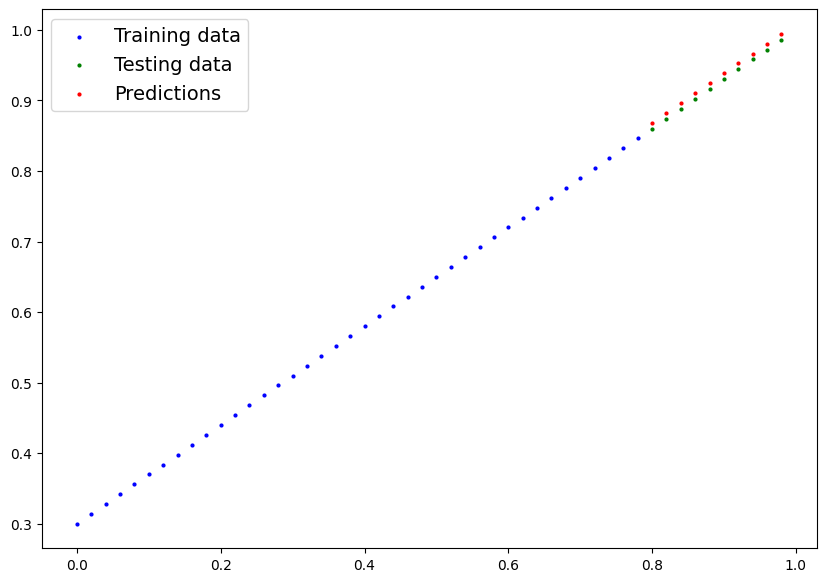

In [463]:
with torch.inference_mode():
    y_preds = model_0(X_test)
plot_predictions(predictions=y_preds)

## Saving a model in PyTorch

### 3 main methods:
* `torch.save()` - allows to save a PyTorch object in Python's pickle format
* `torch.load()` - allows to load a saved PyTorch object
* `torch.nn.Module.load_state_dict()` - allows to laod a model's saved state dictionary

In [464]:
# Saving model
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "linear-regression-model.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save model's state dict
torch.save(obj=model_0.state_dict(), f=MODEL_SAVE_PATH)

## Loading a PyTorch model

In [465]:
# to load in a saved state_dict we have to instantiate a new instance of our model class
loaded_model_0 = LinearRegressionModel()

# load the saved state_dict of model_0 (this will update the new instance with updated params)
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<ipython-input-465-04b90a66e7b7>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))


<All keys matched successfully>

In [466]:
loaded_model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [467]:
loaded_model_0.eval()
with torch.inference_mode():
  loaded_model_preds = loaded_model_0(X_test)
  y_preds = model_0(X_test)

y_preds == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

## 6. Putting it all together
Import PyTorch, plt, etc.
Setup device agnostic code

In [468]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


# 6.1 Data

In [469]:
# Create some data using the linear regression y = weight * X + bias
weight = 0.5
bias = 0.4

# Create range values
start = 0
end = 1
step = 0.02

# Create X and y
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias
X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.4000],
         [0.4100],
         [0.4200],
         [0.4300],
         [0.4400],
         [0.4500],
         [0.4600],
         [0.4700],
         [0.4800],
         [0.4900]]))

In [470]:
# Split data
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]
len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

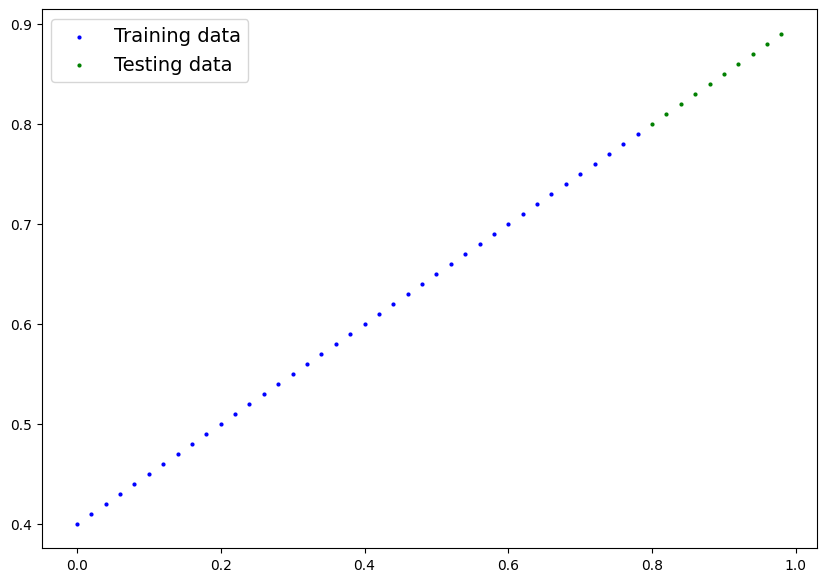

In [471]:
# Plot the data
plot_predictions(X_train, y_train, X_test, y_test)

## 6.2 Building a PyTorch Linear model

In [472]:
class LinearRegressionModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    # Use nn.Linear() for creating the model parameters
    self.linear_layer = nn.Linear(in_features=1,
                                out_features=1)
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.linear_layer(x)
#Set the manual seed
torch.manual_seed(42)
model_1 = LinearRegressionModelV2()
model_1, model_1.state_dict()

(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [473]:
#check the model current device
next(model_1.parameters()).device

device(type='cpu')

In [474]:
model_1.to(device)
next(model_1.parameters()).device

device(type='cuda', index=0)

## 6.3 Training

We need:
* Loss func
* Optimizer
* Training loop
* Testing loop

In [475]:
# Setup loss func
loss_fn = nn.L1Loss() # same as MAE

# Setup our optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.01)

In [476]:
# Training loop
torch.manual_seed(42)

epochs = 300

#Put data on the target device
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)


for epoch in range(epochs):
  model_1.train()

  # 1. Forward pass
  y_pred = model_1(X_train)
  # 2. Calculate the loss
  loss = loss_fn(y_pred, y_train)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Perform backpropagation
  loss.backward()

  # 5. Optimizer step
  optimizer.step()

  ### Testing
  model_1.eval()
  with torch.inference_mode():
    test_pred = model_1(X_test)

    test_loss = loss_fn(test_pred, y_test)

    if epoch % 10 == 0:
      print(f"epoch: {epoch} | loss: {loss} | test_loss: {test_loss} ")


epoch: 0 | loss: 0.5331779718399048 | test_loss: 0.6519762277603149 
epoch: 10 | loss: 0.41796809434890747 | test_loss: 0.5172663927078247 
epoch: 20 | loss: 0.30275818705558777 | test_loss: 0.38255658745765686 
epoch: 30 | loss: 0.18754832446575165 | test_loss: 0.24784670770168304 
epoch: 40 | loss: 0.07233845442533493 | test_loss: 0.113136887550354 
epoch: 50 | loss: 0.015071788802742958 | test_loss: 0.03629780560731888 
epoch: 60 | loss: 0.011527805589139462 | test_loss: 0.02597351185977459 
epoch: 70 | loss: 0.008093987591564655 | test_loss: 0.01838785409927368 
epoch: 80 | loss: 0.0046629877761006355 | test_loss: 0.010115319862961769 
epoch: 90 | loss: 0.003980043809860945 | test_loss: 0.012070352211594582 
epoch: 100 | loss: 0.003980043809860945 | test_loss: 0.012070352211594582 
epoch: 110 | loss: 0.003980043809860945 | test_loss: 0.012070352211594582 
epoch: 120 | loss: 0.003980043809860945 | test_loss: 0.012070352211594582 
epoch: 130 | loss: 0.003980043809860945 | test_loss: 

In [477]:
model_1.state_dict(), weight, bias

(OrderedDict([('linear_layer.weight', tensor([[0.5052]], device='cuda:0')),
              ('linear_layer.bias', tensor([0.3940], device='cuda:0'))]),
 0.5,
 0.4)

## 6.4 Making and evaluating predictions

In [478]:
# Turn model into evaluation mode
model_1.eval()

# make predictions on the test data
with torch.inference_mode():
  y_preds = model_1(X_test)
y_preds, y_test

(tensor([[0.7981],
         [0.8082],
         [0.8183],
         [0.8284],
         [0.8385],
         [0.8487],
         [0.8588],
         [0.8689],
         [0.8790],
         [0.8891]], device='cuda:0'),
 tensor([[0.8000],
         [0.8100],
         [0.8200],
         [0.8300],
         [0.8400],
         [0.8500],
         [0.8600],
         [0.8700],
         [0.8800],
         [0.8900]], device='cuda:0'))

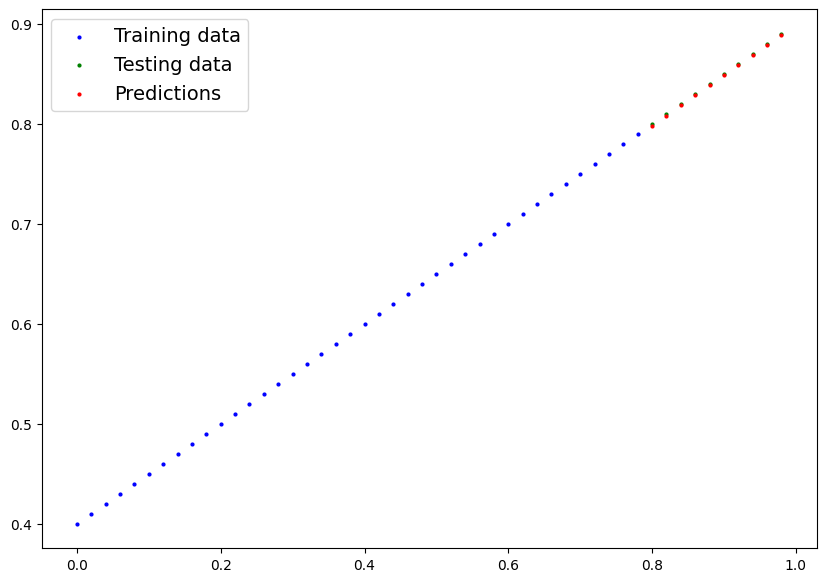

In [479]:
# Check out our model preds visually
plot_predictions(X_train.cpu(), y_train.cpu(), X_test.cpu(), y_test.cpu(), predictions=y_preds.cpu())

## 6.5 Saving a model

In [ ]:
#from pathlib import Path

#MODEL_PATH = Path("models")
#MODEL_PATH.mkdir(parents=True, exist_ok=True)

#MODEL_NAME = "pytorch-linearRegression-model1.pth"
#MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

### 3. Save model's state dict
#torch.save(obj=model_1.state_dict(), f=MODEL_SAVE_PATH)

In [ ]:
### Load a model
#loaded_model_1 = LinearRegressionModelV2()

#loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))
#next(loaded_model_1.parameters()).to(device)